### 0.Imports

In [ ]:
!pip install load-dotenv
!pip install scikit-learn
!pip install pandas
!pip install requests
!pip install tqdm
!pip3 install ipywidgets #restart kernel after installation
!pip install matplotlib
!pip install seaborn

In [2]:
from pandas import read_csv, DataFrame, crosstab
import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import requests
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sn

### 1. Prepare Data & Prompts

#### 1.1 Read Data, filter columns and rename them

In [3]:
data= read_csv('cfpb_compliants.csv')
data=data[['narrative','product']]
data = data.rename(columns={'narrative': 'input', 'product' : 'output'})
data.head()


,input,output
0,currently hold one credit best buy visa paying...,credit_card
1,asked verification debt appeared credit report...,debt_collection
2,loan chase auto car accident car totaled insur...,mortgages_and_loans
3,pas due amount came denied income driven plan ...,mortgages_and_loans
4,attn collection dept submitting complaint refe...,credit_reporting


In [4]:
data.output.value_counts()

output
debt_collection        6642
credit_reporting       6000
mortgages_and_loans    5822
credit_card            5031
retail_banking         3863
Name: count, dtype: int64

##### Experiment: Filter to only work with 256 characters complaints

In [5]:
data_256_filter = data['input'].str.len() < 256
data_256 = data[data_256_filter]
len(data_256)

8071

In [6]:
data_256.output.value_counts()

output
debt_collection        2465
credit_reporting       2362
retail_banking         1187
credit_card            1066
mortgages_and_loans     991
Name: count, dtype: int64

#### 1.2 Create datasets for training and test

In [9]:
data_train, data_test, y_train, y_test = train_test_split(data_256['input'], 
                                                    data_256['output'],
                                                    test_size=0.3,
                                                    random_state=33, 
                                                    stratify=data_256['output'])
data_train = DataFrame(data_train)
data_test = DataFrame(data_test)

#### 1.3 Create training data file ( to be used thru the Tuning Studio UI )

In [41]:

data_train_and_labels = data_train.copy()
data_train_and_labels['output'] = y_train

data_train_and_labels[:2000].to_json('data/2000-compliants_classification_training_examples.json', orient ="records")


In [14]:
data_train_and_labels[:2000].output.value_counts()

output
credit_reporting       621
debt_collection        588
retail_banking         291
credit_card            260
mortgages_and_loans    240
Name: count, dtype: int64

#### 1.4. Create Data Test

##### Experiment: Same number of examples per class

In [12]:
data_train_sample = data_train_and_labels.groupby("output").sample(n=600, random_state=1)
data_train_sample['output'].value_counts()

output
credit_card            600
credit_reporting       600
debt_collection        600
mortgages_and_loans    600
retail_banking         600
Name: count, dtype: int64

In [55]:
data_train_sample.to_json('data/600c_compliants_classification_training_examples.json', orient ="records")

##### Select random 1000 examples


In [17]:
data_test_and_labels = data_test.copy()
data_test_and_labels['output'] = y_test

In [28]:
data_test_and_labels[:1000].to_json('data/testing_examples.json', orient ="records")

In [19]:
data_test_and_labels.output.value_counts()

output
debt_collection        740
credit_reporting       709
retail_banking         356
credit_card            320
mortgages_and_loans    297
Name: count, dtype: int64

#### Go to Tuning Studio

In [ ]:
""" Classification output (verbalizer) :
classify { "credit_card", "debt_collection","mortgages_and_loans", "retail_banking","credit_reporting" } Input: {{input}} Output:
"""

#TODO : fine tuning by code

#### Prepare for Prompting

In [21]:
class Prompt:
    def __init__(self, api_key, endpoint_url):
        self.access_token = api_key
        #self.project_id = project_id
        self.endpoint_url = endpoint_url + "/generate"

    def generate(self, input, model_id, parameters):
    
        Headers = {
            "Authorization": "Bearer " + self.access_token,
            "Content-Type": "application/json",
            "Accept": "application/json"
        }
        data = {
            "model_id": model_id,
            "inputs": [input],
            "parameters": parameters
            #"project_id": self.project_id 
        }
        response = requests.post(self.endpoint_url, json=data, headers=Headers)
        if response.status_code == 200:
            return response.json()["results"][0]
        else:
            raise Exception(response.text)



In [22]:
load_dotenv()
BAM_API_URL = os.getenv("BAM_API_URL")
BAM_API_KEY = os.getenv("BAM_API_KEY")

prompt = Prompt(BAM_API_KEY, BAM_API_URL)

In [23]:
models_json = requests.get(BAM_API_URL + '/models',
                           headers={
                                    'Authorization': f'Bearer {BAM_API_KEY}',
                                    'Content-Type': 'application/json',
                                    'Accept': 'application/json'
                            }).json()

for model in models_json['results']:
        print(model['id'])

bigscience/bloom
cerebras/cerebras-gpt-13b
salesforce/codegen2-16b
flan-t5-xl-mpt-3ch15Lcn-2023-07-24-12-57-43
flan-t5-xl-mpt-pKdM3Qjb-2023-07-27-07-46-21
flan-t5-xl-mpt-yBLhEjJz-2023-07-27-08-47-13
flan-t5-xl-pt-E3H5mH7a-2023-07-26-10-54-20
allenai/cosmo-xl
prakharz/dial-flant5-xl
tiiuae/falcon-40b
google/flan-t5-xl
google/flan-t5-xxl
google/flan-ul2
togethercomputer/gpt-jt-6b-v1
eleutherai/gpt-neox-20b
togethercomputer/gpt-neoxt-chat-base-20b
mosaicml/mpt-30b
mosaicml/mpt-7b
ibm/mpt-7b-instruct
bigscience/mt0-xxl
openassistant/oasst-sft-4-pythia-12b
togethercomputer/redpajama-incite-instruct-7b-v01
bigcode/starcoder
flan-t5-xl-mpt-U88Lnx92-2023-06-26-09-24-15
flan-t5-xl-mpt-SNatZPXo-2023-06-26-14-58-36
google/ul2


In [24]:
instruction_zs="""Determine the class of product expressed in the sentence.
Use either 'credit_card', 'debt_collection','mortgages_and_loans','retail_banking', or 'credit_reporting'.

sentence: {sentence}

class: 
"""

In [25]:
parameters = {
         "decoding_method": "greedy",
         "random_seed": 33,
         "repetition_penalty":1,
         "min_new_tokens": 1,
         "max_new_tokens": 10
}

In [45]:
inputs_test = [{"input": text} for text in data_test_and_labels['input']]
y_test = data_test_and_labels['output']

### 2. Test Performance FLAN-T5 ( withouth prompt tuning)

#### 2.1 ZERO SHOT PROMTING APPROACH

In [ ]:
#TODO: make a bacth
model_id = "google/flan-t5-xl"
results_zs = []
max_examples = 1000
for i in  tqdm(range(max_examples)):
    inp = inputs_test[i]
    results_zs.append(prompt.generate(instruction_zs.format(sentence =inp['input']), model_id, parameters))

In [ ]:
results_zs[:5]

[{'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 78,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 151,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 261,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 88,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 83,
  'stop_reason': 'EOS_TOKEN'}]

In [ ]:
y_pred_zs = [result['generated_text'] for result in results_zs]
y_pred_zs[:3]

['credit_reporting', 'credit_reporting', 'credit_reporting']

In [ ]:
print(accuracy_score(y_pred_zs, y_test[:max_examples]))

0.539


In [ ]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(y_test[:max_examples], y_pred_zs) )

                     precision    recall  f1-score   support

        credit_card       0.77      0.65      0.70       187
   credit_reporting       0.33      0.95      0.49       205
    debt_collection       0.78      0.18      0.30       245
mortgages_and_loans       0.97      0.42      0.59       218
     retail_banking       0.90      0.60      0.72       145

           accuracy                           0.54      1000
          macro avg       0.75      0.56      0.56      1000
       weighted avg       0.74      0.54      0.54      1000



#### 2.2 FEW SHOT PROMTING APPROACH

In [ ]:
few_shot_example=[]
few_shot_examples=[]
for input,output in data_train_and_labels.groupby('output').apply(lambda x: x.sample(2)).values:
    few_shot_example.append(f"sentence: {input}\n class: {output}\n")
few_shot_examples=[''.join(few_shot_example)]

In [ ]:
instruction="""Determine the class of product expressed in the sentence.
Use either 'credit_card', 'debt_collection','mortgages_and_loans', 'retail_banking ' , or 'credit_reporting'.
Use the provided examples as a template.

{few_show_examples}

sentence: {input}

class:
 """


model_id = "google/flan-t5-xl"


results_fs = []
max_examples = 1000
for i in  tqdm(range(max_examples)):
    test = inputs_test[i]
    results_fs.append(prompt.generate(instruction.format(few_show_examples = few_shot_examples[0], input = test['input']), model_id, parameters))
        


100%|██████████| 1000/1000 [26:43<00:00,  1.60s/it]


In [ ]:
y_pred_fs = [result['generated_text'] for result in results_fs]
y_pred_fs[:3]

['credit_reporting', 'retail_banking', 'credit_reporting']

In [ ]:
print(accuracy_score(y_pred_fs, y_test[:1000]))

0.608


In [ ]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(y_test[:1000], y_pred_fs) )

                     precision    recall  f1-score   support

        credit_card       0.84      0.57      0.68       187
  credit_collection       0.00      0.00      0.00         0
   credit_reporting       0.41      0.92      0.57       205
    debt_collection       0.75      0.37      0.49       245
        health_care       0.00      0.00      0.00         0
mortgages_and_loans       0.97      0.48      0.64       218
     retail_banking       0.65      0.82      0.72       145
       unemployment       0.00      0.00      0.00         0

           accuracy                           0.61      1000
          macro avg       0.45      0.39      0.39      1000
       weighted avg       0.73      0.61      0.61      1000



/Users/maria.navas/Documents/GitHub/prompt_tuning_example/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maria.navas/Documents/GitHub/prompt_tuning_example/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maria.navas/Documents/GitHub/prompt_tuning_example/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

### 3. Test Performance Tuned FLAN-T5 

In [ ]:
models_json = requests.get(BAM_API_URL + '/models',
                           headers={
                                    'Authorization': f'Bearer {BAM_API_KEY}',
                                    'Content-Type': 'application/json',
                                    'Accept': 'application/json'
                            }).json()

for model in models_json['results']:
        print(model['id'])


bigscience/bloom
cerebras/cerebras-gpt-13b
salesforce/codegen2-16b
flan-t5-xl-mpt-3ch15Lcn-2023-07-24-12-57-43
flan-t5-xl-mpt-pKdM3Qjb-2023-07-27-07-46-21
flan-t5-xl-mpt-yBLhEjJz-2023-07-27-08-47-13
flan-t5-xl-pt-E3H5mH7a-2023-07-26-10-54-20
allenai/cosmo-xl
prakharz/dial-flant5-xl
tiiuae/falcon-40b
google/flan-t5-xl
google/flan-t5-xxl
google/flan-ul2
togethercomputer/gpt-jt-6b-v1
eleutherai/gpt-neox-20b
togethercomputer/gpt-neoxt-chat-base-20b
mosaicml/mpt-30b
mosaicml/mpt-7b
ibm/mpt-7b-instruct
bigscience/mt0-xxl
openassistant/oasst-sft-4-pythia-12b
togethercomputer/redpajama-incite-instruct-7b-v01
bigcode/starcoder
flan-t5-xl-mpt-U88Lnx92-2023-06-26-09-24-15
flan-t5-xl-mpt-SNatZPXo-2023-06-26-14-58-36
google/ul2


#### 3.1 Prompt Tuning Approach

In [ ]:
model_id_pt = "flan-t5-xl-pt-E3H5mH7a-2023-07-26-10-54-20"

results_pt = []
max_examples = 1000
for i in  tqdm(range(max_examples)):
    test =  inputs_test[i]
    results_pt.append(prompt.generate(instruction_zs.format(sentence =test['input']), model_id_pt, parameters))

In [ ]:
y_pred_pt = [result['generated_text'] for result in results_pt]

print(accuracy_score(y_pred_pt, y_test[:max_examples]))

0.772


In [ ]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(y_test[:max_examples], y_pred_pt) )

                     precision    recall  f1-score   support

        credit_card       0.77      0.76      0.76       187
   credit_reporting       0.69      0.71      0.70       205
    debt_collection       0.80      0.69      0.74       245
mortgages_and_loans       0.83      0.85      0.84       218
     retail_banking       0.76      0.90      0.83       145

           accuracy                           0.77      1000
          macro avg       0.77      0.78      0.77      1000
       weighted avg       0.77      0.77      0.77      1000



#### 3.2 Multi-Task Prompt Tuning Approach

In [49]:
#model_id_mpt_2000 = "flan-t5-xl-mpt-3ch15Lcn-2023-07-24-12-57-43"
#model_id_mpt_400c = "flan-t5-xl-mpt-pKdM3Qjb-2023-07-27-07-46-21"
model_id_mpt_600c = "flan-t5-xl-mpt-yBLhEjJz-2023-07-27-08-47-13"

results_mpt_600c = []
max_examples = 1000
for i in  tqdm(range(max_examples)):
    test =  inputs_test[i]
    results_mpt_600c.append(prompt.generate(instruction_zs.format(sentence =test['input']), model_id_mpt_600c, parameters))
        

100%|██████████| 1000/1000 [28:36<00:00,  1.72s/it] 


In [52]:
y_pred_mpt_600c = [result['generated_text'] for result in results_mpt_600c]

print(accuracy_score(y_pred_mpt_600c, y_test[:max_examples]))

0.736


In [54]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(y_test[:max_examples], y_pred_mpt_600c) )

                     precision    recall  f1-score   support

        credit_card       0.69      0.66      0.67       200
   credit_reporting       0.67      0.79      0.72       200
    debt_collection       0.80      0.63      0.70       200
mortgages_and_loans       0.81      0.80      0.80       200
     retail_banking       0.75      0.81      0.78       200

           accuracy                           0.74      1000
          macro avg       0.74      0.74      0.74      1000
       weighted avg       0.74      0.74      0.74      1000



In [ ]:
model_id_mpt_2000 = "flan-t5-xl-mpt-3ch15Lcn-2023-07-24-12-57-43"

results_mpt_2000 = []
max_examples = 1000
for i in  tqdm(range(max_examples)):
    test =  inputs_test[i]
    results_mpt_2000.append(prompt.generate(instruction_zs.format(sentence =test['input']), model_id_mpt_2000, parameters))

In [ ]:
y_pred_mpt_2000 = [result['generated_text'] for result in results_mpt_2000]

print(accuracy_score(y_pred_mpt_2000, y_test[:max_examples]))

0.828


In [ ]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(y_test[:max_examples], y_pred_mpt_2000) )

                     precision    recall  f1-score   support

        credit_card       0.77      0.82      0.80       187
   credit_reporting       0.77      0.81      0.79       205
    debt_collection       0.84      0.79      0.82       245
mortgages_and_loans       0.90      0.86      0.88       218
     retail_banking       0.86      0.87      0.86       145

           accuracy                           0.83      1000
          macro avg       0.83      0.83      0.83      1000
       weighted avg       0.83      0.83      0.83      1000



### 4. Compare results after Prompt Tuning

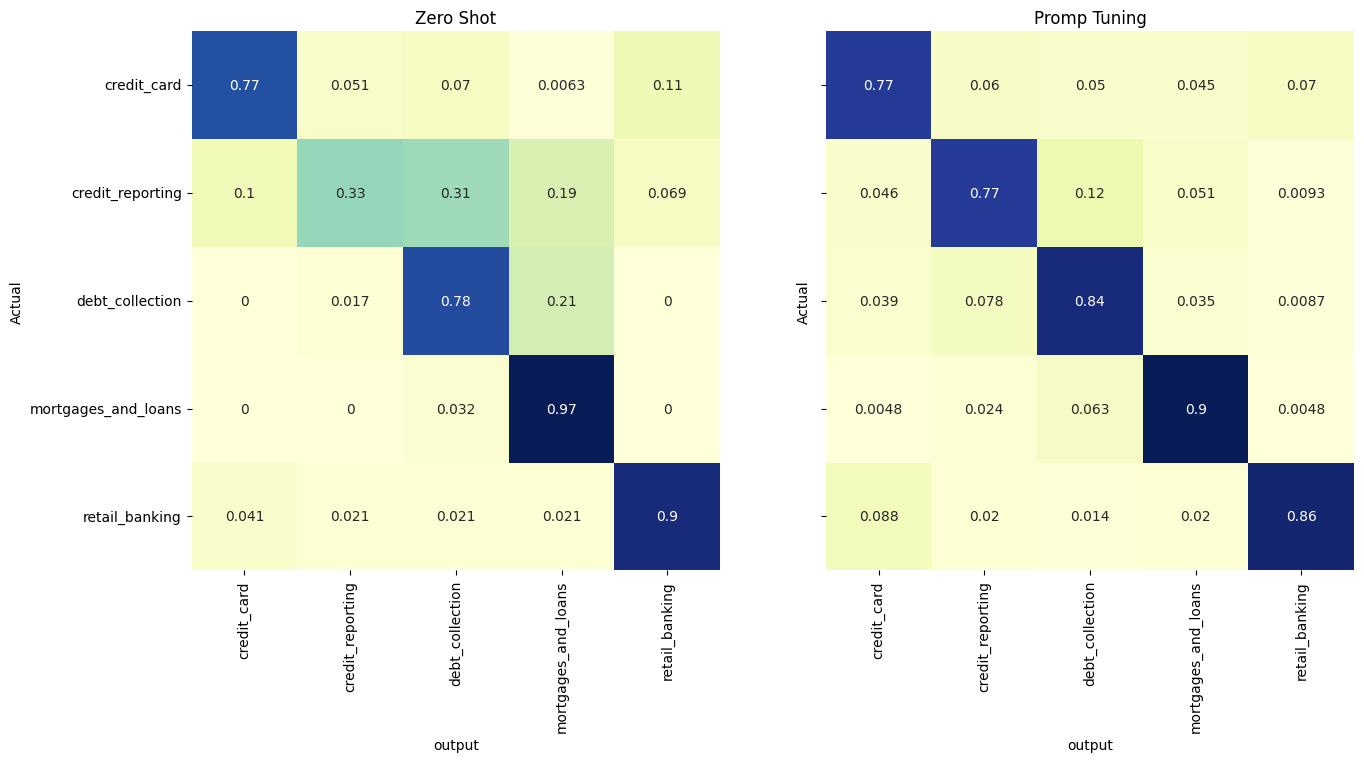

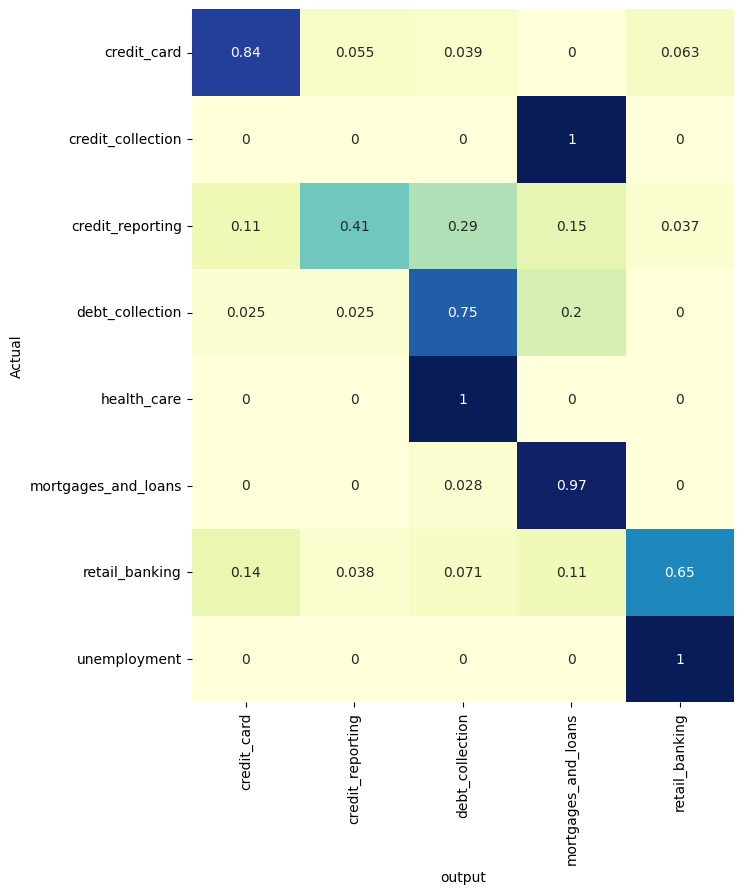

In [ ]:
#TO BE DONE- EXAMPLE CODE


zero_shot_confusion_df = crosstab(y_pred_zs, y_test[:max_examples], rownames=['Actual'], normalize='index')
few_shot_confusion_df = crosstab(y_pred_fs, y_test[:max_examples], rownames=['Actual'], normalize='index')
prompt_tuning_confusion_df = crosstab(y_pred_pt, y_test[:max_examples], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,7))

sn.heatmap(zero_shot_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(prompt_tuning_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("Before ")
ax2.title.set_text("Muti-task Prompt Tuning")
ax2.set_yticklabels([])

plt.show()

figure3, ax3 = plt.subplots(figsize=(7,9))


sn.heatmap(few_shot_confusion_df, annot=True, cmap="YlGnBu", ax=ax3, cbar=False)
ax2.title.set_text("Few Shot")
plt.show()


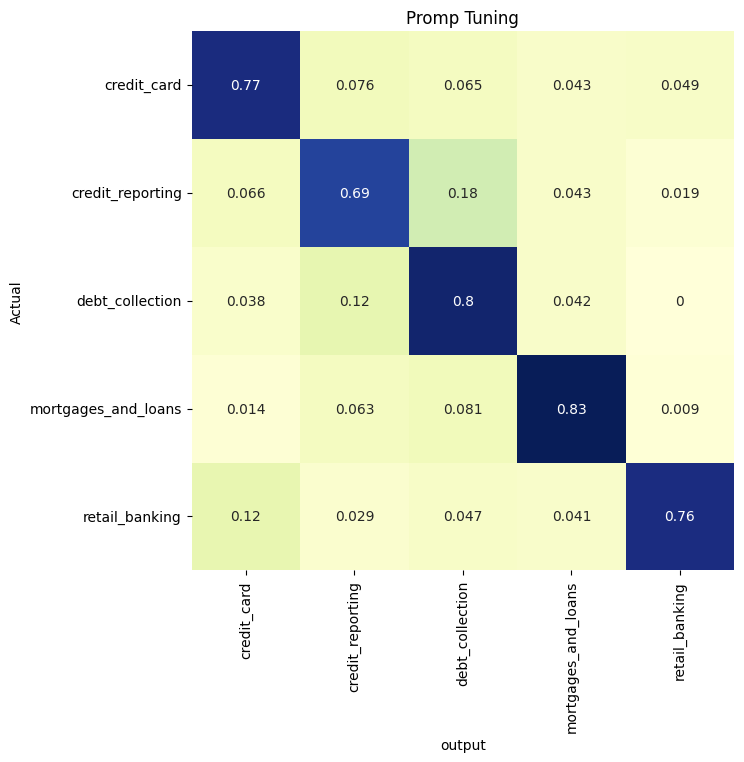

In [ ]:
prompt_tuning_confusion_df = crosstab(y_pred_pt, y_test[:max_examples], rownames=['Actual'], normalize='index')

figure4, ax4 = plt.subplots(figsize=(7,7))
sn.heatmap(prompt_tuning_confusion_df, annot=True, cmap="YlGnBu", ax=ax4, cbar=False)
ax4.title.set_text("Promp Tuning")
plt.show()

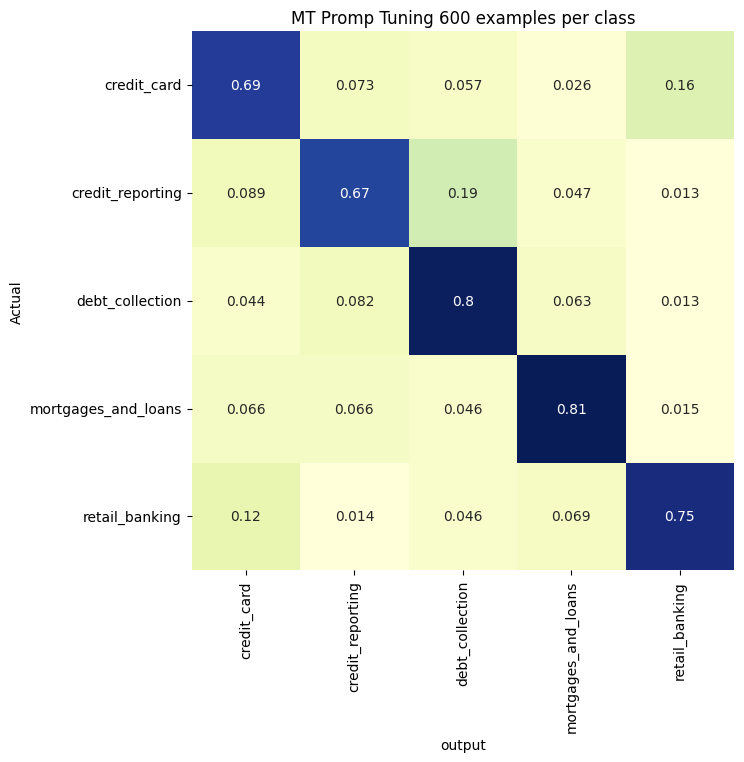

In [57]:
mt_promp_tuning_600c_confusion_df = crosstab(y_pred_mpt_600c, y_test[:max_examples], rownames=['Actual'], normalize='index')

figure5, ax5 = plt.subplots(figsize=(7,7))
sn.heatmap(mt_promp_tuning_600c_confusion_df, annot=True, cmap="YlGnBu", ax=ax5, cbar=False)
ax5.title.set_text("MT Promp Tuning 600 examples per class")
plt.show()